# 自己回帰プロセスのモデル化 P91~
- 自己回帰プロセスとは
- 偏自己相関関数（PACF）を定義する
- PACFプロットを使って自己回帰プロセスの次数を特定する
- 自己回帰モデルを使って時系列を予測する

前章で移動平均プロセスMA(q)を学んだ。<br>
式は以下の通り
$$
y_{t}=\mu+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+・・・+\theta_{q}\epsilon_{t-q}
$$
と定義され、現在の値が現在と過去の誤差項に線形従属する。

# 5.1

以下の図は2000年以降の小売店の週平均来客者数を表したデータ。データ店は1000個ある。

<img src="src5-1.png">

この図から読み取れることは

- 長期的なトレンドが存在し、途中に山と谷が存在
- 経時的なトレンドが存在⇒時系列が定常プロセスではない
- 周期的なパターンがみられない⇒季節性の影響はかなり少ない

前章と同様にベースとなるプロセスを特定する。<br>
⇒ランダムウォークプロセスや移動平均プロセスが関与するか確認<br>

具体的には以下の手順で進める。

<img src="src5-1-2.png">

# 5.2 自己回帰プロセス(AR)を定義する

    　自己回帰プロセスは出力変数が以前の値に線形従属する
    　⇒自己回帰プロセスは変数自体に対する変数の回帰

     一般的なAR(p)モデルの式は以下の通り
$$
y_{t}=C+\phi_{1}\ y_{t-1}+\phi_{2}\ y_{t-2}+・・・+\phi_{p}\ y_{t-p}+\epsilon_{t}
$$
　　　ここでpは次数

   　　　p=1のとき$y_{t}=C+\phi_{1}\ y_{t-1}+\epsilon_{t}$で表せて
   
   　　　特に$\phi_{1}=1$のとき$y_{t}=C+y_{t-1}+\epsilon_{t}$となり、ランダムウォークプロセスとなる

# 5.3 定常的なARプロセスの次数を特定する

In [10]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#CSVファイルをDataFrameに持ち込む
df=pd.read_csv('foot_traffic.csv')
#データの最初の5行を表示
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


<img src="src5-3.png">

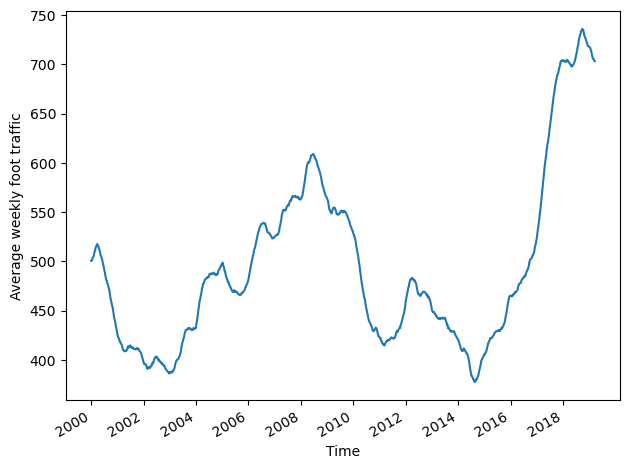

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

#小売店の週平均来店者数をプロット
ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [14]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240682
p-value: 0.6838808917896216


- ADF統計量が大きな負の値ではない
- p値が0.68>0.05なので<br>
**時系列の単位根が存在すること**が棄却できなかった、非定常である。<br>

従って定常化させるために変換を行う⇒差分化

In [21]:
#データに一次差分を適用し、結果をfoot_traffic_diffに格納
foot_traffic_diff=np.diff(df['foot_traffic'],n=1)

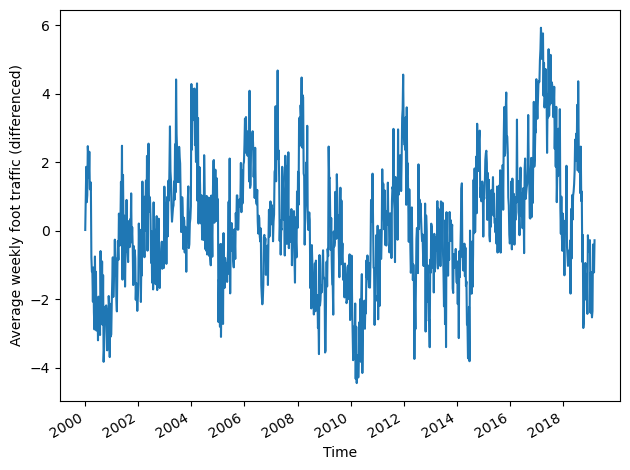

In [30]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.2682313474220495
p-value: 6.3693176547810965e-06


- ADF統計量=$-5.26・・・$
- p値が$6.37*10^{-5}$<0.05なので<br>
定常のため**時系列の単位根が存在すること**が棄却できた(帰無仮説の棄却)

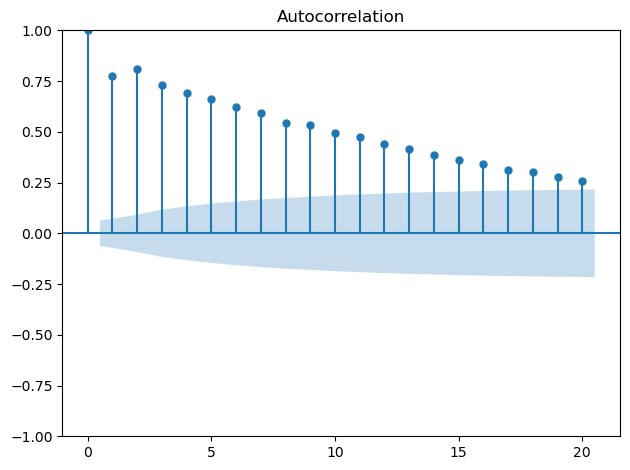

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(foot_traffic_diff, lags=20);
plt.tight_layout()

- ラグ0以降、有意な自己相関係数が続いている⇒ランダムウォークではない
- ラグが増えるにつれて係数が指数関数的に減衰⇒おそらく自己回帰プロセスと推定

## なぜか

ランダムウォークの場合、自己相関係数（ACF）は**ラグが増えても減衰しない**。つまり「だらーっと高いまま」で推移する。

今回はラグ1、2、3…と自己相関が**有意ではあるが徐々に減衰している**  
⇒ これは**ランダムウォークのような「持続的な影響」ではなく、過去の影響が徐々に弱まっている**ということ。

### 【自己相関係数が指数関数的に減衰 ⇒ 自己回帰プロセス（AR）と推定される】

自己回帰モデル（ARモデル）は例えばこう：

 $X_t = \phi X_{t-1} + \epsilon_t $（AR(1)の例）

このとき、自己相関関数（ACF）は理論的に：

 $ \rho_k = \phi^k $

つまり、**ラグkが大きくなるごとに指数関数的に減衰**します$(|\phi|<1$の場合）。

なので、ACFが「指数的に落ちていく」ように見える場合：

- → これは**AR過程の特徴**  
- → 特に**AR(1)**や**AR(p)**などの自己回帰構造があると推定される

# 5.3.1 偏自己相関関数(PACF)

定常的な自己回帰プロセスの次数の特定⇒ACFプロット<br>
ACFプロットでこの情報を得られない場合は偏自己相関関数(PACF)を使う<br>
自己相関は２つの時系列の線形関係の度合いを確認するものなのでACFはラグが大きくなるにあたって2値の相関関係がどのように変化するのか表す。<br>
次のようなARプロセスを考える。
$$
y_{t}=0.33y_{t-1}+0.50y_{t-2}
$$
$y_{t}$と$y_{t-2}$の関係を評価するときACFを使う。ただしこの時$y_{t-1}$も$y_{t}$に影響を与える。<br>
従ってACFで評価しても真の$y_{t}$と$y_{t-2}$の関係を評価することはできない。<br>
⇒$y_{t-1}$の影響を取り除く必要がある。<br>
これが偏自己相関を導入する理由となる。<br>

具体的にはPACFが測定するのは時系列のラグをとった値の相関から中間の相関の影響を取り除いた時の相関である。<br>
このような値を**交絡変数**と呼ぶ。<br>
ここからはPACFをプロットすることで上の式のプロセスの次数が判明するか検証する。

In [34]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

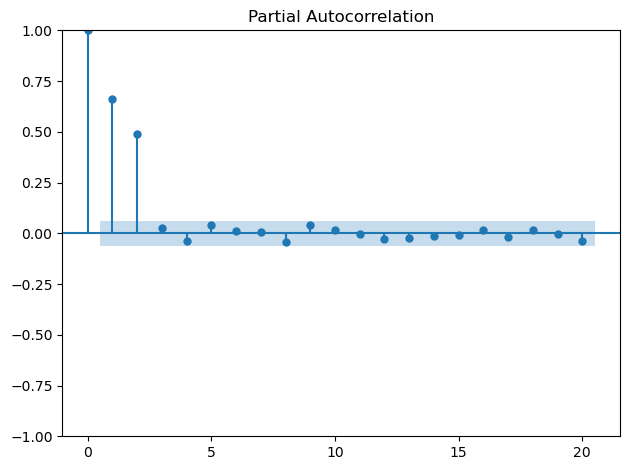

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);

plt.tight_layout()

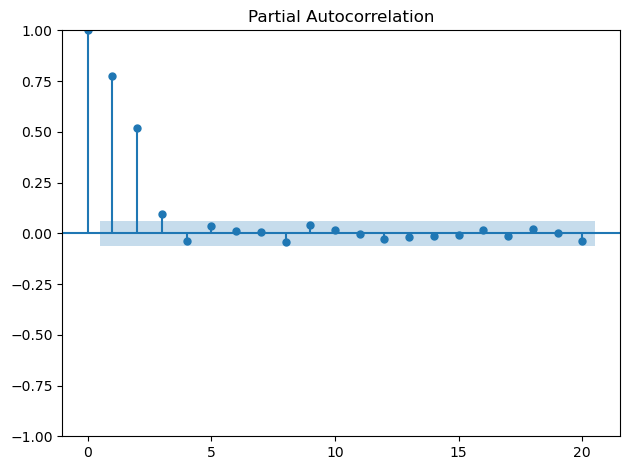

In [36]:
plot_pacf(foot_traffic_diff, lags=20);

plt.tight_layout()

# 5.4 ARプロセスを予測する

In [37]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52]
test = df_diff[-52:]

print(len(train))
print(len(test))

947
52


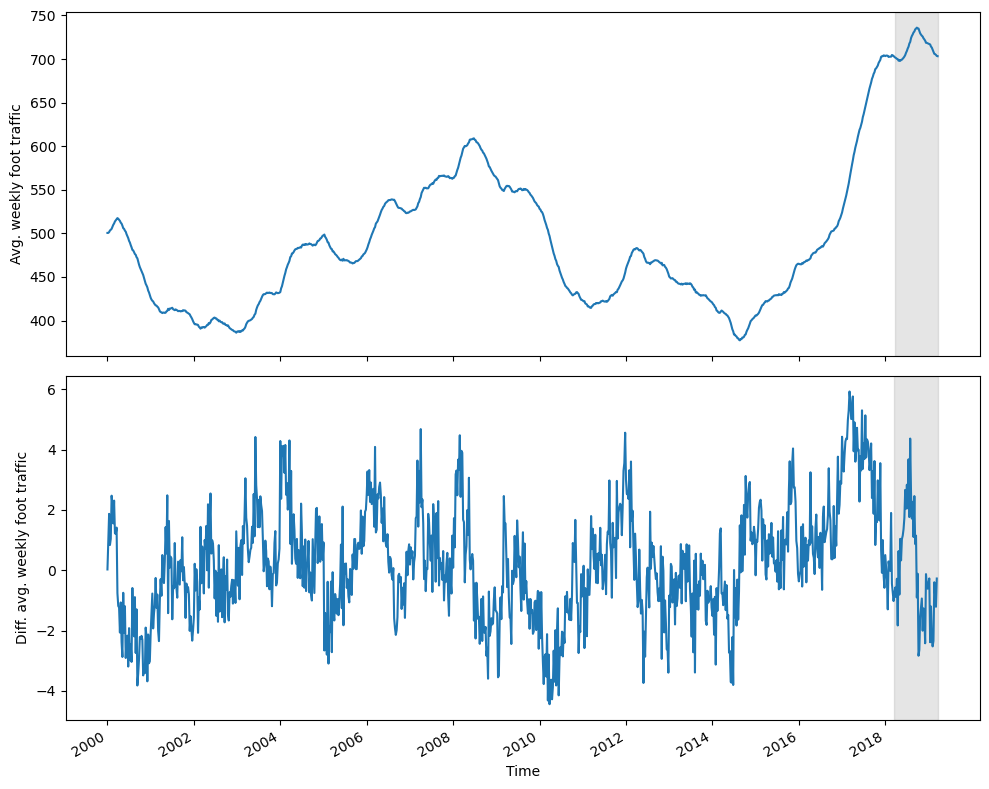

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

今回の目標は小売店の翌週の平均来店者数を予測することなので、テストデータセットでローリング予測をする。<br>
次の時間ステップの予測方法は3つ
- ベースラインとして過去の平均値に基づく手法
- 最後の既知の値を使う方法
- AR(3)モデル<br>

前回と同様に平均二乗誤差(MSE)を使い、各予測手法の性能を評価。

In [44]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


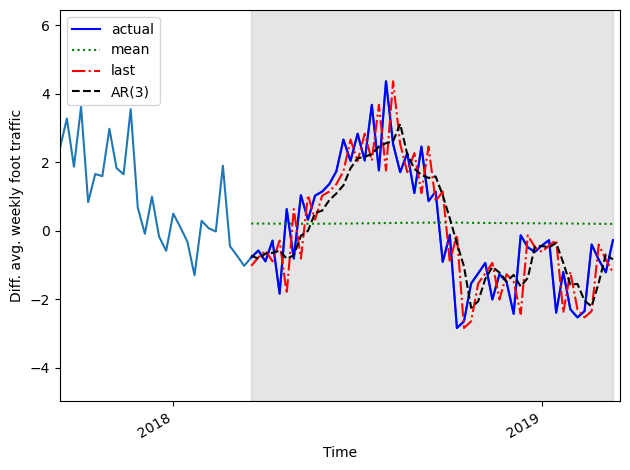

In [48]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [49]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164783025


これによりMSEが最も小さいのはAR(3)モデルなので<br>
翌週の平均来店者数を予測する最も性能が良い手法はこのモデルであると結論付けられる。

ここからは変換したものを逆変換、今回は差分化の逆変換を行う。

変換をもとに戻すには、予測値の累積和を求めて、もとの時系列の訓練データセットの最後の値に足す。

In [52]:
df['pred_foot_traffic']=pd.Series()

df['pred_foot_traffic'][948:]=df['foot_traffic'].iloc[948]+\
                              test['pred_AR'].cumsum()

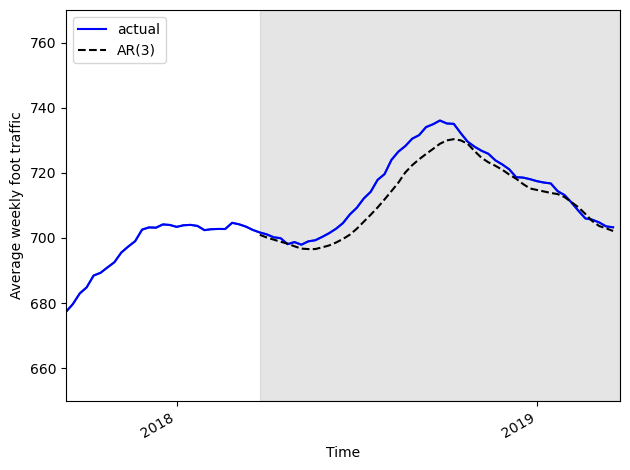

In [53]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [54]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.4780335607372614


ここでMAEを求めることにより予測値が実際の来客者数を平均して3.45人上回るか下回るかという<br>
ビジネス的な意味を持たせることが出来る

# 5.5
定常的なAR(p)プロセスの次数を特定するうえでACFプロットが助けにならない
⇒ラグpまで有意な偏自己相関係数が示されるPACFをプロットする

ACF、PACFでも情報を得られないとき<br>
ex)どちらもゆっくりとした減衰や正弦波を示す⇒MA(p)、AR(p)プロセスの次数を特定できない<br>
⇒予測できるのはAR(p)、MA(q)を組み合わせたより複雑なプロセス(**自己回帰移動平均プロセス(ARMA(p))**)となる。

# 5.6 実習

### 5.6.1 AR(2)プロセスのシミュレーションと予測

定常的なAR(2)プロセスをシミュレートする。<br>
ここではstatsmodelsライブラリのArmaProcess関数を使って次のプロセスをシミュレートする。
$$
y_{t}=0.33y_{t-1}+0.50y_{t-2}
$$
1.この演習で使う1,000個のサンプルを生成。

In [55]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

2.シミュレートされた自己回帰プロセスをプロットする。<br>
3.ADF検定をし、プロセスが定常かどうかを確認する。定常でない場合は差分を適用する。<br>
4.ACFをプロットする。ゆっくり減衰しているだろうか。<br>
5.PACFをプロットする。ラグ2の後に有意な係数が見つかるだろうか。<br>
6.シミュレートした時系列を訓練データセットとテストデータセットに分割する。<br>
  最初の800時間ステップを訓練データセットに割り当て、残りをテストデータセットに割り当てる。<br>
7.テストデータセットに対する予測値を生成する。過去の平均値、最後の既知の値、AR(2)モデルの３つの手法を使う。<br>
　rolling_forecast関数を使い、windowパラメータを2に設定する。<br>
8.予測値をプロットする。<br>
9.MSEを計測し、最も性能が良いモデルを特定する。<br>
10.MSEを棒グラフとしてプロットする。<br>

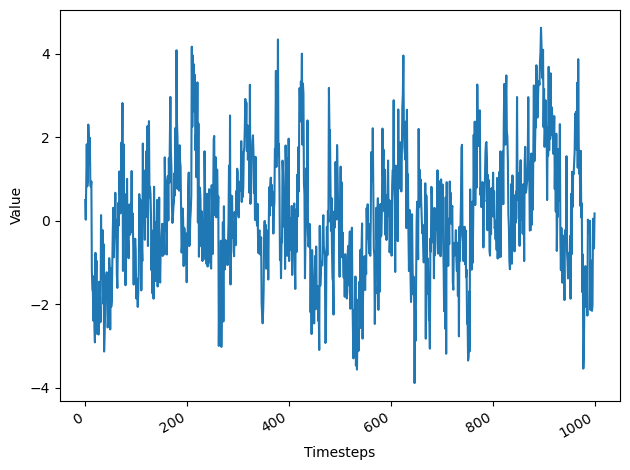

In [56]:
#2.シミュレートされた自己回帰プロセスをプロットする。
fig, ax = plt.subplots()

ax.plot(AR2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [58]:
#3.ADF検定をし、プロセスが定常かどうかを確認する。定常でない場合は差分を適用する。
ADF_result = adfuller(AR2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.566606021416905
p-value: 2.9145161293763083e-11


ここではp値が低いため定常であると判断できる。

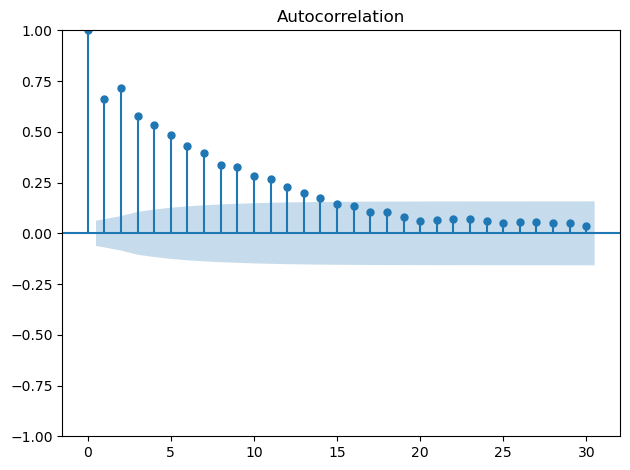

In [59]:
#4.ACFをプロットする。ゆっくり減衰しているだろうか。
plot_acf(AR2_process, lags=30);

plt.tight_layout()

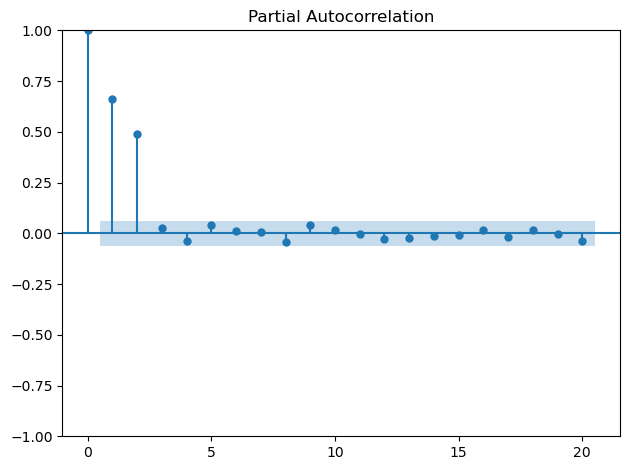

In [60]:
#5.PACFをプロットする。ラグ2の後に有意な係数が見つかるだろうか。
plot_pacf(AR2_process, lags=20);

plt.tight_layout()

In [61]:
#6.シミュレートした時系列を訓練データセットとテストデータセットに分割する。
  #最初の800時間ステップを訓練データセットに割り当て、残りをテストデータセットに割り当てる。

df = pd.DataFrame({'value': AR2_process})

train = df[:800]
test = df[800:]

In [62]:
#7.テストデータセットに対する予測値を生成する。過去の平均値、最後の既知の値、AR(2)モデルの３つの手法を使う。
#rolling_forecast関数を使い、windowパラメータを2に設定する。

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [63]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


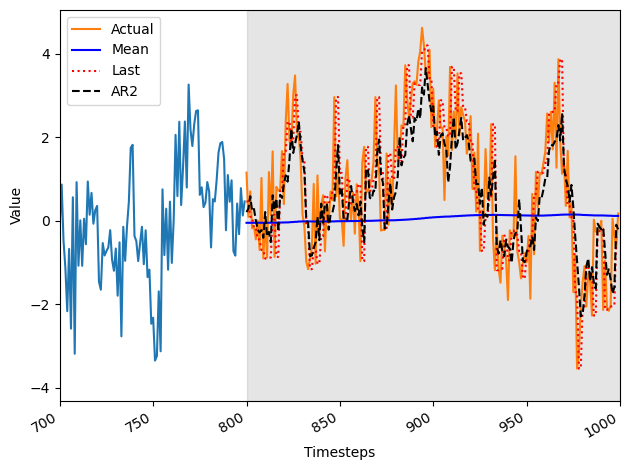

In [64]:
#8.予測値をプロットする。

fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_AR'], 'k--', label='AR2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [67]:
#9.MSEを計測し、最も性能が良いモデルを特定する。
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_AR = mean_squared_error(test['value'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9692635186347849


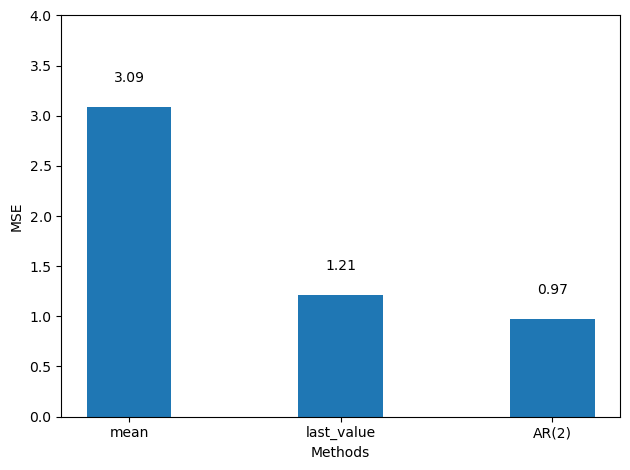

In [68]:
#10.MSEを棒グラフとしてプロットする。
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()


### 5.6.2 AR(p)プロセスのシミュレーションと予測
前項の実習と同じこと行う。ただし、AR(p)プロセスは各自の選択。<br>
また、3次または4次の自己回帰プロセスをシミュレートすること。サンプル数は10,000個生成する。<br>
予測を行うときにrolling_forecast関数のwindowパラメータを様々な値で試してみること。<br>
パラメータの大きさはモデルの性能にどのように影響を与えるだろうか。<br>
また、MSEが最も小さくなる値はあるか。

In [5]:
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)

ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.33, -0.50, -0.07])

AR3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

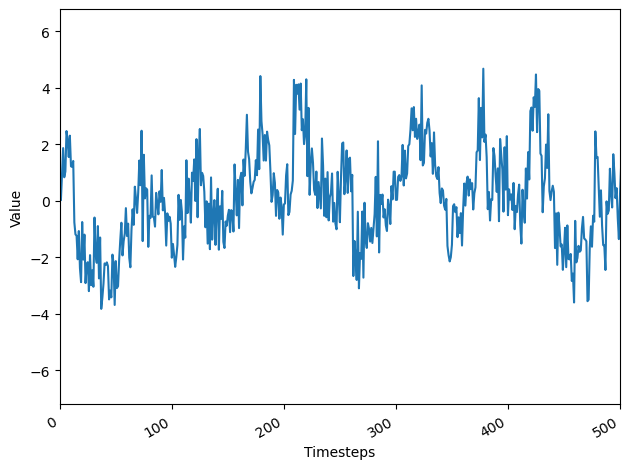

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(AR3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(AR3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -17.432292735214418
p-value: 4.759612221578908e-30


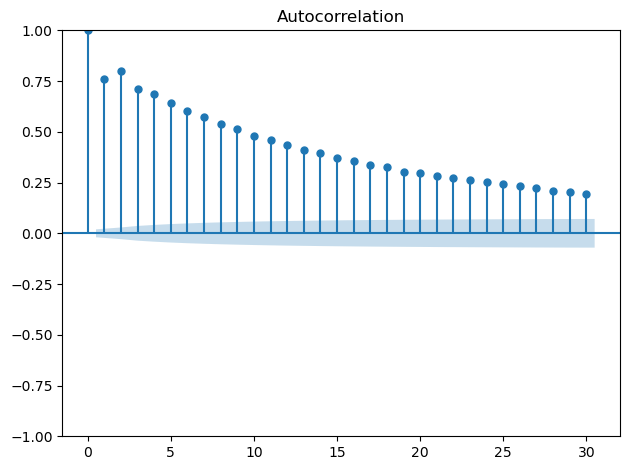

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(AR3_process, lags=30);

plt.tight_layout()

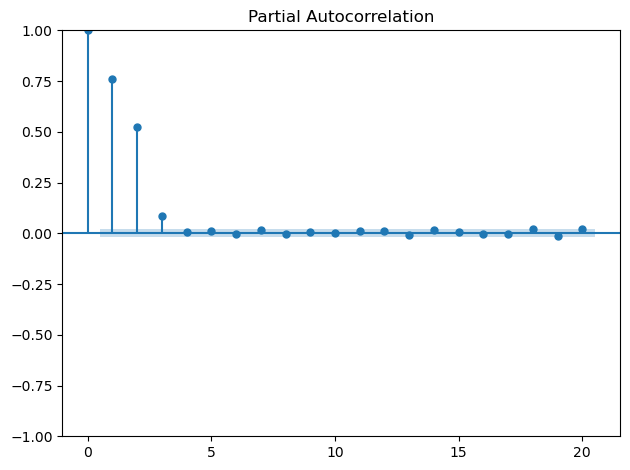

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR3_process, lags=20);

plt.tight_layout()

In [15]:
import pandas as pd

AR3_df = pd.DataFrame({'value': AR3_process})

AR3_train = AR3_df[:-200]
AR3_test = AR3_df[-200:]

print(len(AR3_train))

9800


In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [18]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

TRAIN_LEN = len(AR3_train)
HORIZON = len(AR3_test)
WINDOW = 2

pred_mean = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

AR3_test['pred_mean'] = pred_mean
AR3_test['pred_last_value'] = pred_last_value
AR3_test['pred_AR'] = pred_AR

AR3_test.head()

IndentationError: expected an indented block after function definition on line 1 (3755841604.py, line 3)

# 5.7 まとめ
- 自己回帰プロセスでは、現在の値が過去の値に線形従属する。
- 定常プロセスのACFプロットがゆっくり減衰するとき、自己回帰プロセスの可能性が高い。
- 偏自己相関は時系列のラグをとった値の相関から中間の相関の影響を取り除いた時の相関を表す。
- 定常的な自己回帰プロセスのPACFをプロットすると、そのプロセスの次数pが明らかになる。<br>
有意な係数が見つかるのはラグpまでである。